# Check GPU Availability

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Apr 23 14:42:09 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L4                      Off | 00000000:00:03.0 Off |                    0 |
| N/A   33C    P8              11W /  72W |      1MiB / 23034MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Upload generated spectrograms to Google Colab

In [2]:
from google.colab import files

uploaded = files.upload()

Saving images_original.zip to images_original.zip


In [3]:
!unzip images_original.zip

Archive:  images_original.zip
   creating: images_original/blues/
  inflating: images_original/blues/blues00000.png  
  inflating: images_original/blues/blues00001.png  
  inflating: images_original/blues/blues00002.png  
  inflating: images_original/blues/blues00003.png  
  inflating: images_original/blues/blues00004.png  
  inflating: images_original/blues/blues00005.png  
  inflating: images_original/blues/blues00006.png  
  inflating: images_original/blues/blues00007.png  
  inflating: images_original/blues/blues00008.png  
  inflating: images_original/blues/blues00009.png  
  inflating: images_original/blues/blues00010.png  
  inflating: images_original/blues/blues00011.png  
  inflating: images_original/blues/blues00012.png  
  inflating: images_original/blues/blues00013.png  
  inflating: images_original/blues/blues00014.png  
  inflating: images_original/blues/blues00015.png  
  inflating: images_original/blues/blues00016.png  
  inflating: images_original/blues/blues00017.png 

# Preparing the dataset with 10-fold cv

In [4]:
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPU


In [5]:
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory

tf.random.set_seed(42)
training_images_filepath = "./images_original"
xdim = 224
ydim = 224

# Load the entire dataset
spectograms = image_dataset_from_directory(
    training_images_filepath,
    image_size=(xdim, ydim),
    batch_size=50,
    shuffle=True
)

Found 999 files belonging to 10 classes.


In [6]:
num_folds = 10

def get_fold_i(i):
    train_fold = spectograms.take(i).concatenate(spectograms.skip(i + 4)).cache()
    val_fold = spectograms.skip(i).take(2).cache()
    test_fold = spectograms.skip(i + 2).take(2).cache()
    return train_fold, val_fold, test_fold

In [7]:
train_folds, val_folds, test_folds = [], [], []
for i in range(num_folds):
    train_fold, val_fold, test_fold = get_fold_i(i)
    train_folds.append(train_fold)
    val_folds.append(val_fold)
    test_folds.append(test_fold)

In [8]:
import numpy as np

def predict(model, data):
  return np.argmax(model.predict(data), axis = 1)

# Define the experiment procedures

In [12]:
import keras
from keras import layers
from keras.callbacks import EarlyStopping

def one_fold_experiment(train, validation):
  conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(xdim, ydim, 3)
  )

  conv_base.trainable = False

  # Define the model
  inputs = keras.Input(shape=(xdim, ydim, 3))
  x = keras.applications.vgg16.preprocess_input(inputs)
  x = conv_base(inputs)
  x = layers.Flatten()(x)
  x = layers.Dense(256, activation = "relu")(x)
  outputs = layers.Dense(10, activation="softmax")(x)
  model = keras.Model(inputs, outputs)

  model.compile(loss="sparse_categorical_crossentropy",
                optimizer="adam",
                metrics=["accuracy"])

  # Create an early stopping callback
  early_stopping = EarlyStopping(
      monitor='val_accuracy',
      min_delta=0.001,
      patience=10,
      verbose=1,
      mode='max',
      restore_best_weights=True
  )

  history_1 = model.fit(
      train,
      epochs=50,
      validation_data=validation,
      verbose=0,
      callbacks=[early_stopping]
  )

  conv_base.trainable = True
  for layer in conv_base.layers[:-8]:
      layer.trainable = False

  model.compile(loss="sparse_categorical_crossentropy",
                optimizer=keras.optimizers.Adam(learning_rate=1e-5),
                metrics=["accuracy"])

  history_2 = model.fit(
      train,
      epochs=50,
      validation_data=validation,
      verbose=0,
      callbacks=[early_stopping]
  )

  return model, history_1, history_2

# Do the experiment

In [14]:
import copy
from sklearn.metrics import accuracy_score, f1_score

best_models = []
histories_1, histories_2 = [], []
test_accs, test_f1s = [], []

for i in range(num_folds):
  train, val, test = train_folds[i], val_folds[i], test_folds[i]
  model, history_1, history_2 = one_fold_experiment(train, val)
  y_pred = predict(model, test)
  y_true = np.array([label.numpy() for _, label in test.unbatch()])

  acc = accuracy_score(y_true, y_pred)
  f1 = f1_score(y_true, y_pred, average='macro')
  test_accs.append(acc)
  test_f1s.append(f1)
  best_models.append(model)
  histories_1.append((copy.deepcopy(history_1.history['accuracy']), copy.deepcopy(history_1.history['val_accuracy'])))
  histories_2.append((copy.deepcopy(history_2.history['accuracy']), copy.deepcopy(history_2.history['val_accuracy'])))
  print(f"Accuracy of the model at fold {i + 1}: {acc:.3f}")
  print(f"f1 of the model at fold {i + 1}: {f1:.3f}")


Restoring model weights from the end of the best epoch: 15.
Epoch 25: early stopping
Restoring model weights from the end of the best epoch: 10.
Epoch 20: early stopping
2/2 [==============================] - 0s 143ms/step
Accuracy of the model at fold 1: 0.840
f1 of the model at fold 1: 0.838
Restoring model weights from the end of the best epoch: 7.
Epoch 17: early stopping
Restoring model weights from the end of the best epoch: 6.
Epoch 16: early stopping
2/2 [==============================] - 0s 142ms/step
Accuracy of the model at fold 2: 0.880
f1 of the model at fold 2: 0.882
Restoring model weights from the end of the best epoch: 22.
Epoch 32: early stopping
Restoring model weights from the end of the best epoch: 3.
Epoch 13: early stopping
2/2 [==============================] - 0s 145ms/step
Accuracy of the model at fold 3: 0.850
f1 of the model at fold 3: 0.837
Restoring model weights from the end of the best epoch: 5.
Epoch 15: early stopping
Restoring model weights from the e

2/2 [==============================] - 0s 139ms/step
Accuracy of the model at fold 4: 0.930
f1 of the model at fold 4: 0.923
Restoring model weights from the end of the best epoch: 24.
Epoch 34: early stopping
Restoring model weights from the end of the best epoch: 2.
Epoch 12: early stopping


2/2 [==============================] - 0s 143ms/step
Accuracy of the model at fold 5: 0.900
f1 of the model at fold 5: 0.895
Restoring model weights from the end of the best epoch: 19.
Epoch 29: early stopping
Restoring model weights from the end of the best epoch: 1.
Epoch 11: early stopping
2/2 [==============================] - 0s 143ms/step
Accuracy of the model at fold 6: 0.860
f1 of the model at fold 6: 0.837
Restoring model weights from the end of the best epoch: 10.
Epoch 20: early stopping
Restoring model weights from the end of the best epoch: 5.
Epoch 15: early stopping
2/2 [==============================] - 1s 140ms/step
Accuracy of the model at fold 7: 0.860
f1 of the model at fold 7: 0.848
Restoring model weights from the end of the best epoch: 17.
Epoch 27: early stopping
Restoring model weights from the end of the best epoch: 3.
Epoch 13: early stopping
2/2 [==============================] - 1s 142ms/step
Accuracy of the model at fold 8: 0.860
f1 of the model at fold 8:

In [15]:
print(f"Average accuracy across 10 folds: {100 * np.mean(test_accs):.2f}%")
print(f"Average accuracy across 10 folds: {np.mean(test_f1s):.3f}")

Average accuracy across 10 folds: 87.30%
Average accuracy across 10 folds: 0.866


# Visualize the results

In [16]:
train_histories = []
val_histories = []
for i in range(num_folds):
  train_histories.append(np.array(histories_1[i][0] + histories_2[i][0]))
  val_histories.append(np.array(histories_1[i][1] + histories_2[i][1]))

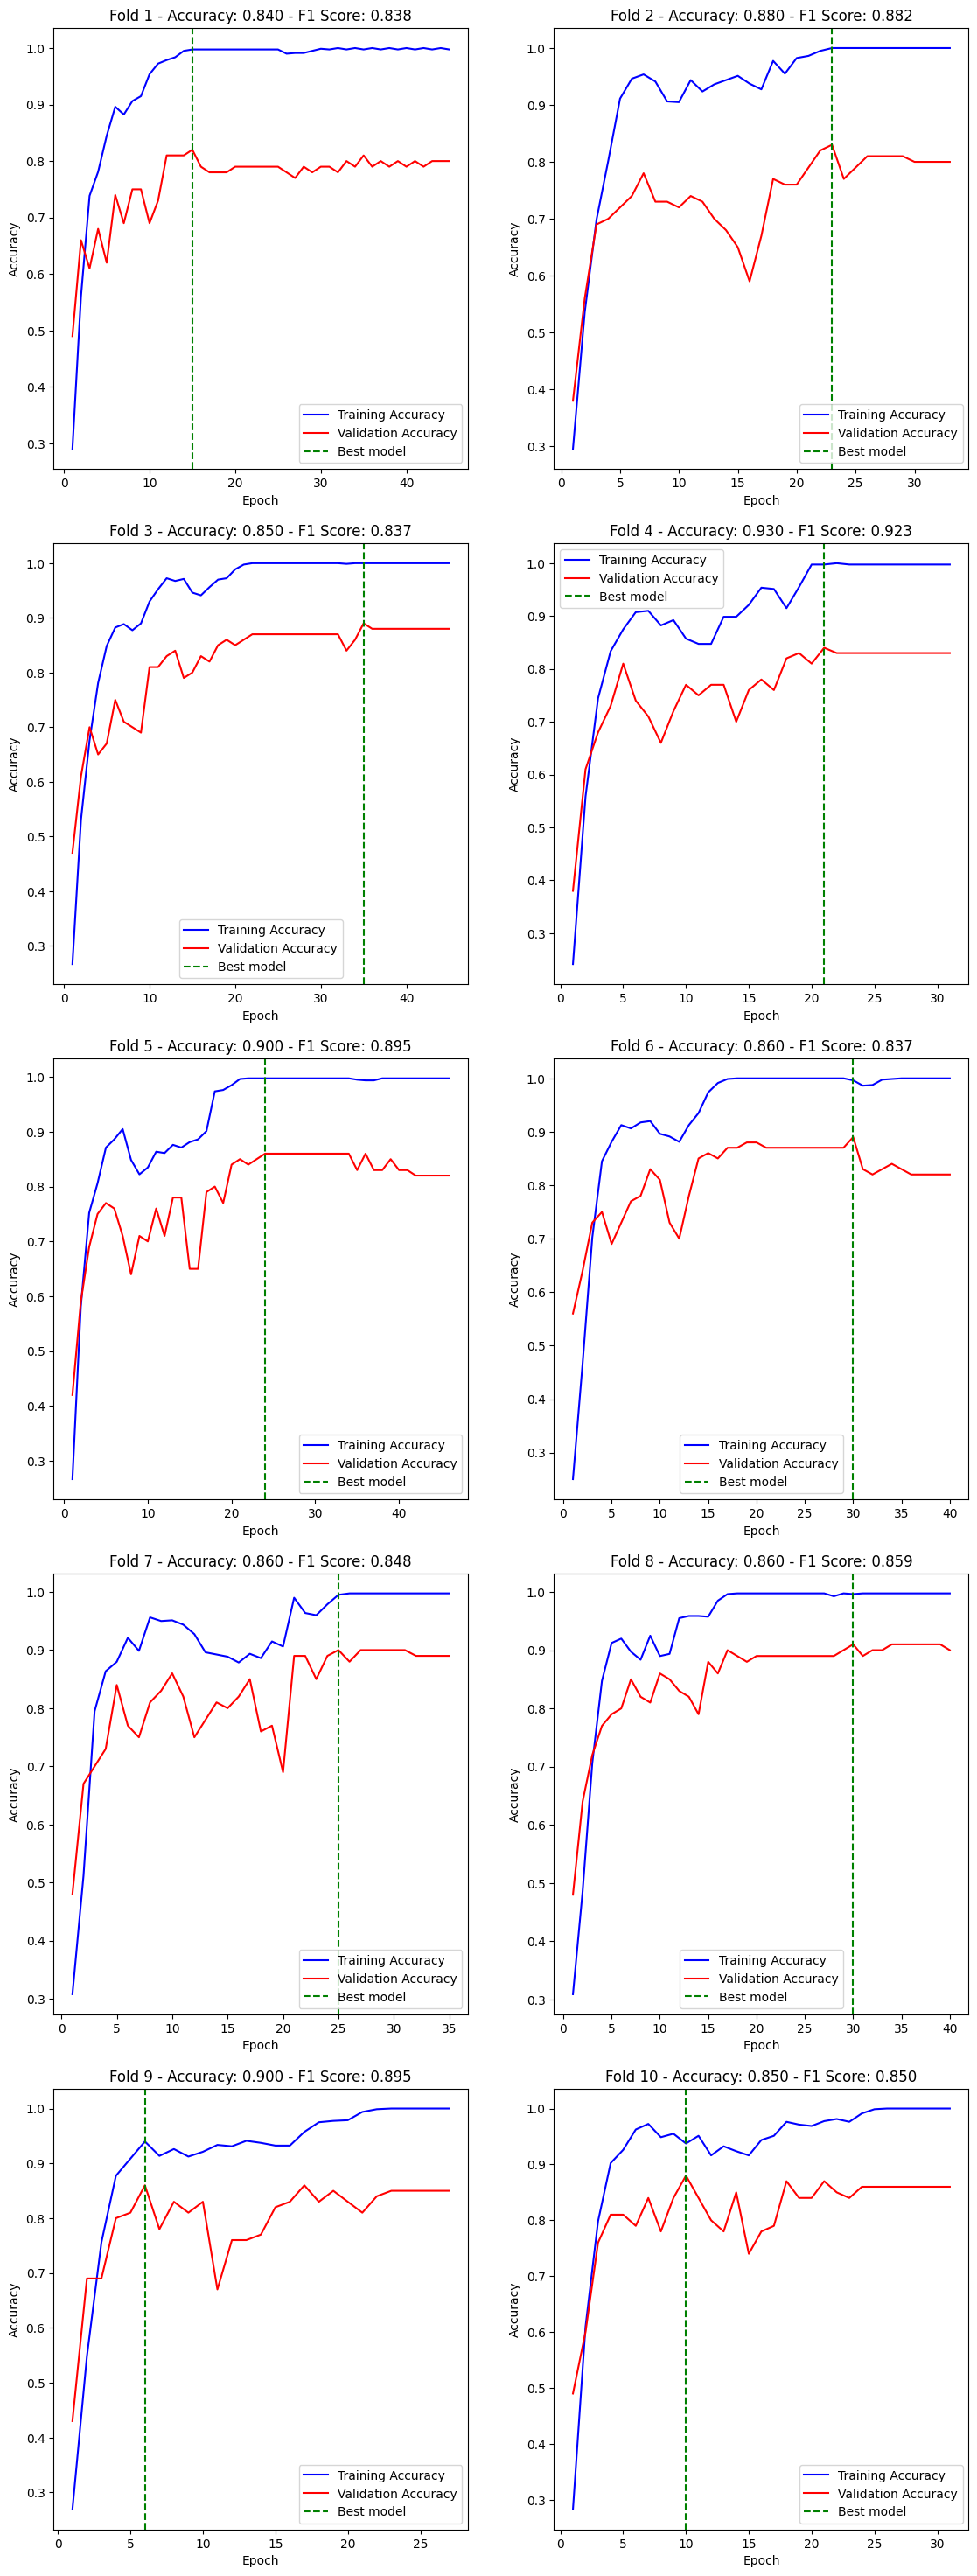

In [17]:
import matplotlib.pyplot as plt

num_rows = (num_folds + 1) // 2
num_cols = 2

fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 6 * num_rows))
fig.tight_layout(pad=4.0)

for i in range(num_folds):
    row = i // num_cols
    col = i % num_cols
    ax = axes[row, col] if num_rows > 1 else axes[col]

    train_acc = train_histories[i]
    val_acc = val_histories[i]
    epochs = range(1, len(train_acc) + 1)

    ax.plot(epochs, train_acc, 'b-', label='Training Accuracy')
    ax.plot(epochs, val_acc, 'r-', label='Validation Accuracy')

    best_epoch = np.argmax(val_acc) + 1
    ax.axvline(x=best_epoch, color='g', linestyle='--', linewidth=1.5, label='Best model')

    ax.set_title(f'Fold {i + 1} - Accuracy: {test_accs[i]:.3f} - F1 Score: {test_f1s[i]:.3f}')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy')
    ax.legend()

plt.show()

In [18]:
def visualize_confusion_matrices(confusion_matrices, class_names=None, titles=None, grand_title='Confusion matrices', cmap='Blues'):
    if class_names is None:
        class_names = ['blues', 'classical', 'country', 'disco', 'hiphop',
                       'jazz', 'metal', 'pop', 'reggae', 'rock']

    # Set titles to split names if not provided
    if titles is None:
        match len(confusion_matrices):
            case 1: titles = ('Full dataset')
            case 2: titles = ('Train', 'Test')
            case 3: titles = ('Train', 'Val', 'Test')

    num_subplots = len(confusion_matrices)
    fig, axes = plt.subplots(1, num_subplots, figsize=(6 * num_subplots, 6))

    for idx in range(len(confusion_matrices)):
        confusion_mat = confusion_matrices[idx]
        ax = axes[idx] if num_subplots > 1 else axes

        im = ax.imshow(confusion_mat, interpolation='nearest', cmap=cmap)

        # Add a color bar
        cbar = ax.figure.colorbar(im, ax=ax, shrink=0.7)

        # Set the tick marks and labels
        tick_marks = np.arange(len(class_names))
        ax.set_xticks(tick_marks)
        ax.set_yticks(tick_marks)
        ax.set_xticklabels(class_names, rotation=45, ha='right')
        ax.set_yticklabels(class_names)

        # Add labels to each cell
        thresh = confusion_mat.max() / 2.
        for i in range(confusion_mat.shape[0]):
            for j in range(confusion_mat.shape[1]):
                ax.text(j, i, format(confusion_mat[i, j], 'd'),
                        ha="center", va="center",
                        color="white" if confusion_mat[i, j] > thresh else "black")

        # Set the axis labels and title
        ax.set_xlabel('Predicted Label')
        ax.set_ylabel('True Label')
        ax.set_title(titles[idx])

    plt.suptitle(grand_title)
    fig.tight_layout()

In [19]:
from sklearn.metrics import confusion_matrix

conf_matrices = []
titles = []

for i in range(num_folds):
  model = best_models[i]
  test = test_folds[i]
  y_pred = predict(model, test)
  y_true = np.array([label.numpy() for _, label in test.unbatch()])

  titles.append(f"Confusion matrix for fold {i+1} on test data")
  conf_matrices.append(confusion_matrix(y_true, y_pred))

2/2 [==============================] - 0s 143ms/step


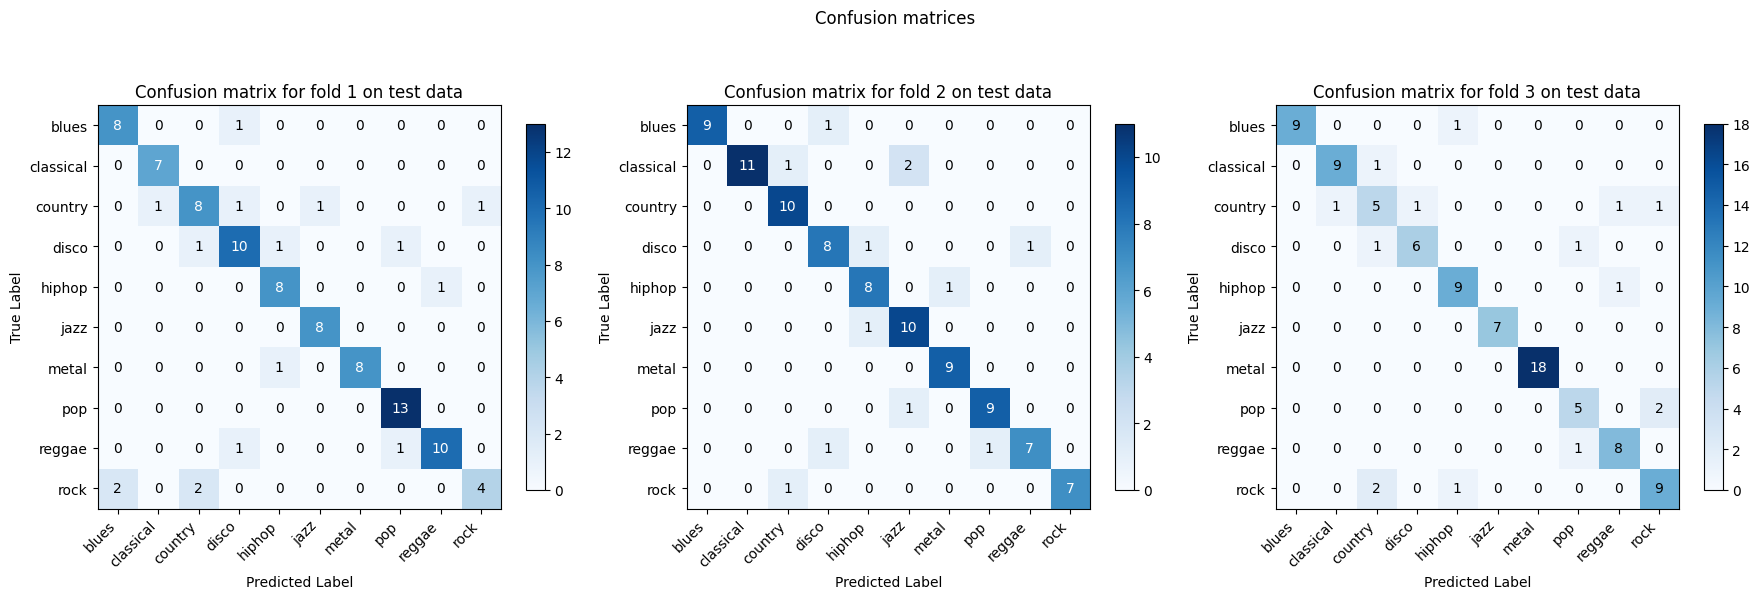

In [20]:
visualize_confusion_matrices(conf_matrices[:3], titles=titles[:3])

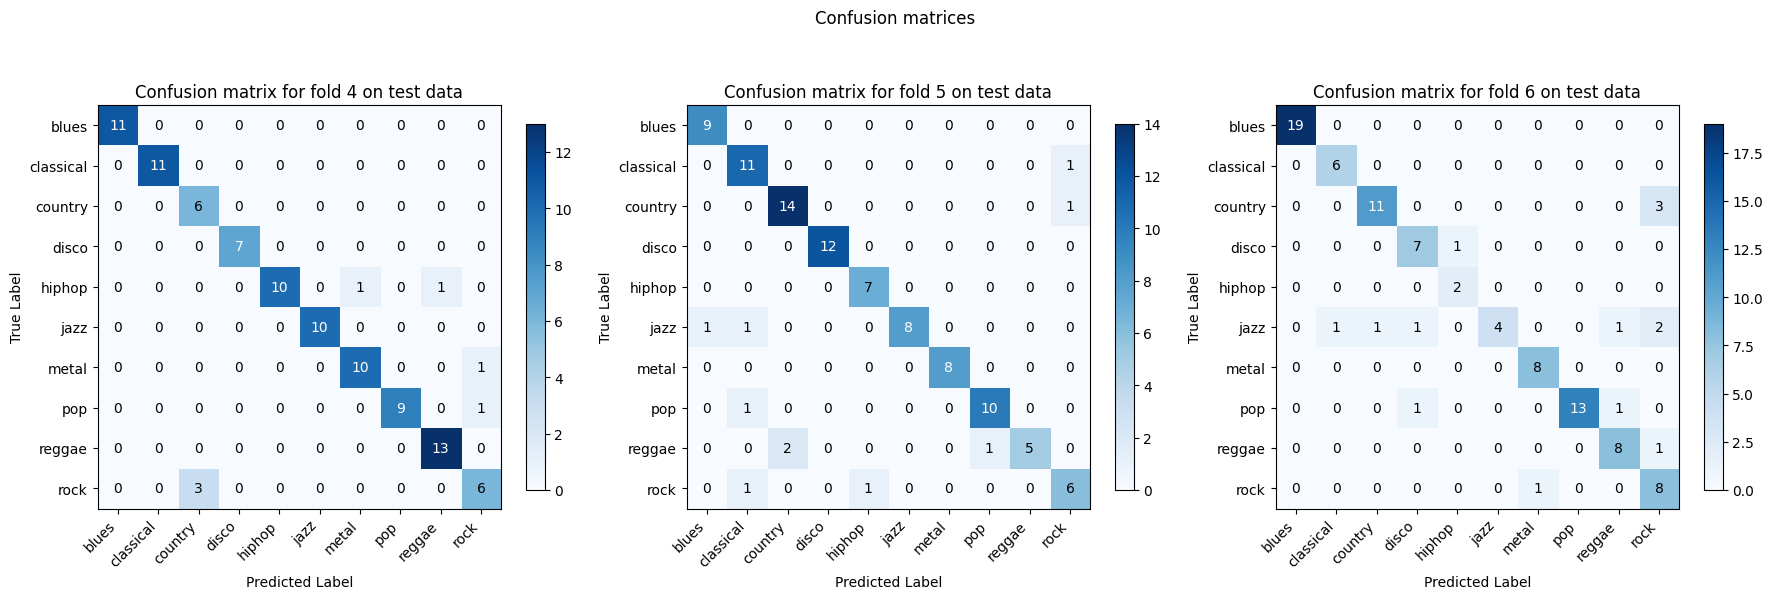

In [21]:
visualize_confusion_matrices(conf_matrices[3:6], titles=titles[3:6])

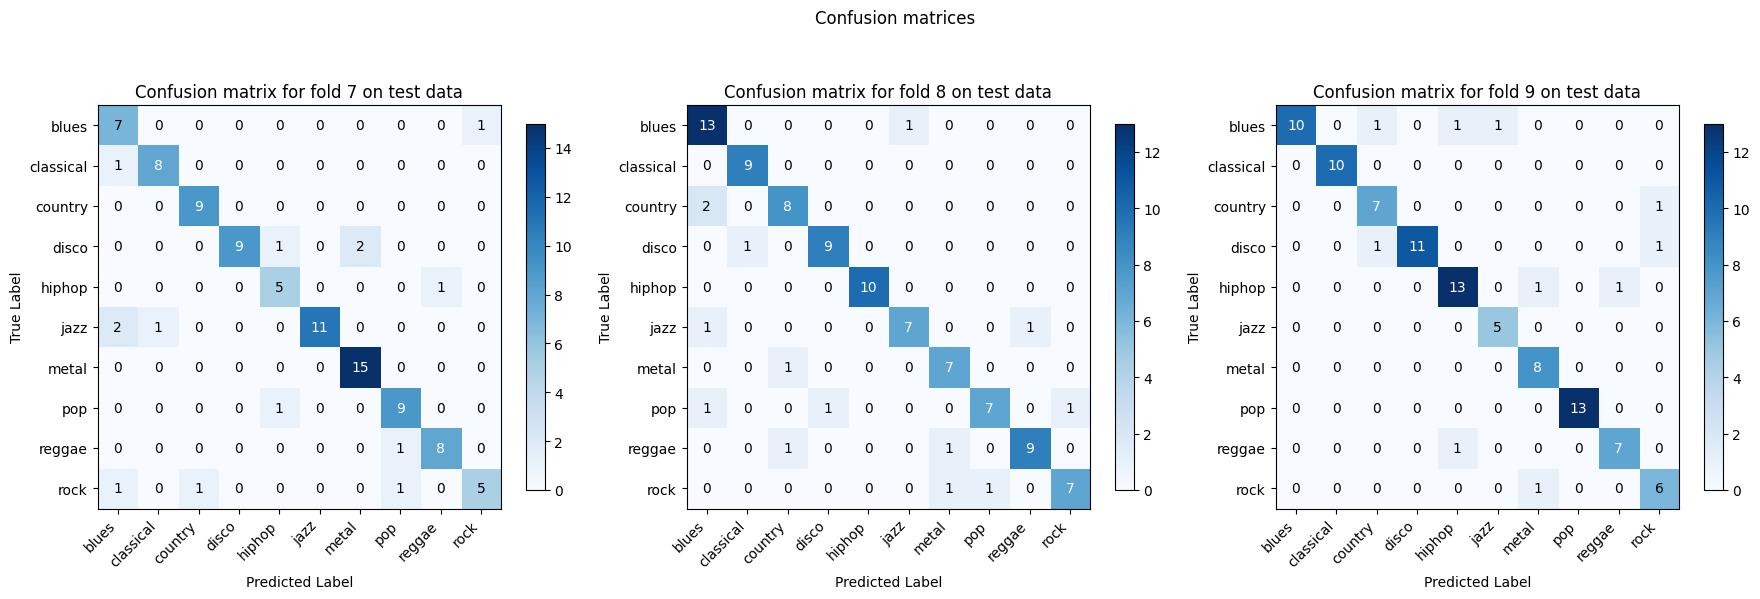

In [22]:
visualize_confusion_matrices(conf_matrices[6:9], titles=titles[6:9])

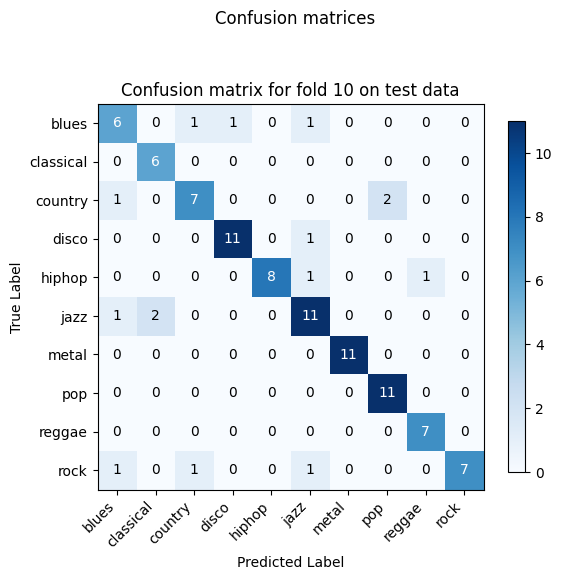

In [23]:
visualize_confusion_matrices(conf_matrices[9:10], titles=titles[9:10])

# Visualize the model structure

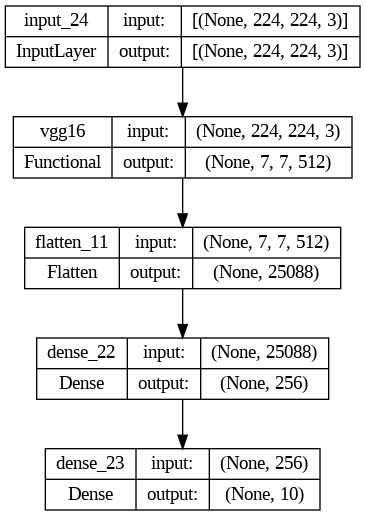

In [24]:
from keras.utils import plot_model

conv_base = keras.applications.vgg16.VGG16(
  weights="imagenet",
  include_top=False,
  input_shape=(xdim, ydim, 3)
)

conv_base.trainable = False

# Define the model
inputs = keras.Input(shape=(xdim, ydim, 3))
x = keras.applications.vgg16.preprocess_input(inputs)
x = conv_base(inputs)
x = layers.Flatten()(x)
x = layers.Dense(256, activation = "relu")(x)
outputs = layers.Dense(10, activation="softmax")(x)
model = keras.Model(inputs, outputs)

plot_model(model, show_shapes=True, show_layer_names=True)

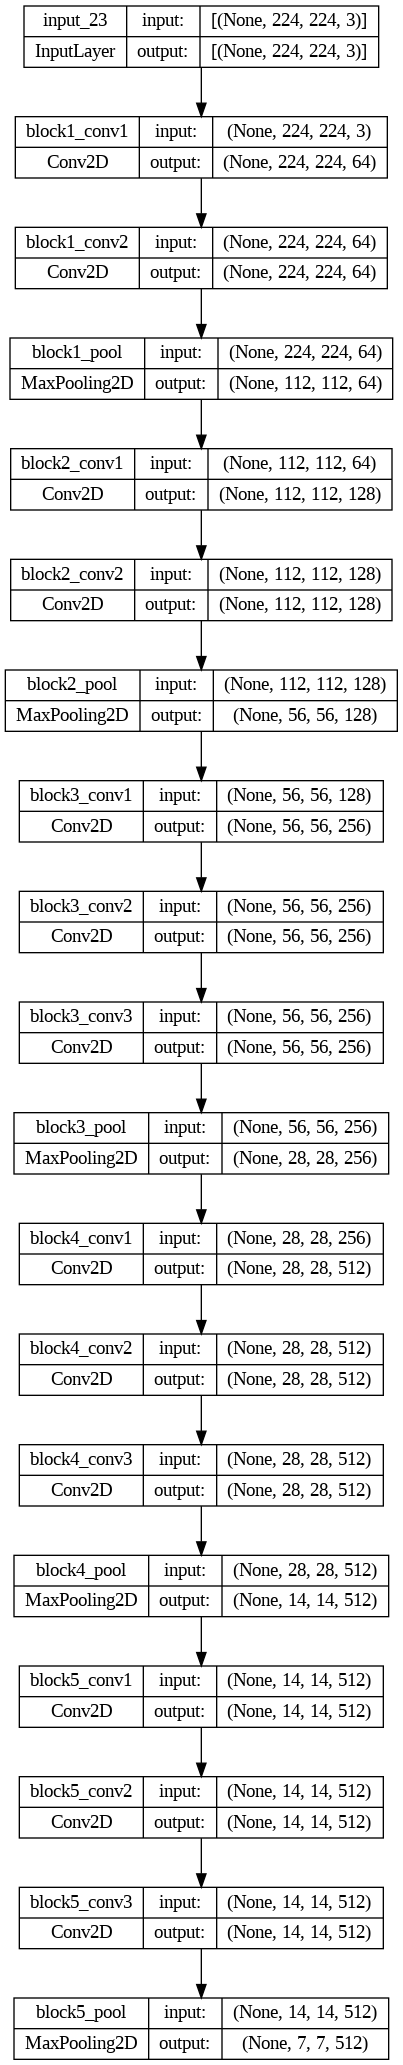

In [25]:
plot_model(conv_base, show_shapes=True, show_layer_names=True)